In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from obspy import read
from scipy import signal
from sklearn.model_selection import train_test_split
from PIL import Image
from torchvision import transforms
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
from datetime import datetime, timedelta
import json


# Set device to CPU
device = torch.device("cpu")

In [2]:
lunar_catalog_path = '../../data/lunar_data/training/catalogs/apollo12_catalog_GradeA_final.csv'
lunar_data_directory = '../../data/lunar_data/training/data/S12_GradeA/'
martian_data_directory = '../../data/martian_data/training/'
save_dir = '../../data/lunar_preprocessed_images/'  # Directory to save preprocessed images

In [3]:
def convert_rel_to_abs_time(start_time, time_rel):
    """
    Convert relative time to absolute time using the trace start time.
    """
    return (start_time + timedelta(seconds=float(time_rel))).strftime('%Y-%m-%dT%H:%M:%S.%f')


# Apply bandpass filter to seismic trace
def apply_bandpass_filter(trace, sampling_rate, freqmin=0.5, freqmax=3.0):
    sos = signal.butter(4, [freqmin, freqmax], btype='bandpass', fs=sampling_rate, output='sos')
    return signal.sosfilt(sos, trace)

In [4]:
# Plot filtered trace and spectrogram, mark arrival times, and save images
def plot_and_save_trace_spectrogram(mseed_file, arrival_time_rel, save_dir, filename, combine_images=True):
    # Read mseed file and extract the trace
    st = read(mseed_file)
    tr = st[0]
    tr_data = tr.data
    tr_times = tr.times()
    sampling_rate = tr.stats.sampling_rate
    starttime = tr.stats.starttime.datetime

    # Convert relative time to absolute if provided
    arrival_time_abs = convert_rel_to_abs_time(starttime, arrival_time_rel) if arrival_time_rel else None

    # Apply bandpass filter to the trace data
    filtered_trace = apply_bandpass_filter(tr_data, sampling_rate)

    # Generate spectrogram
    f, t, sxx = signal.spectrogram(filtered_trace, sampling_rate)

    # Create figure for plotting trace and spectrogram
    fig = plt.figure(figsize=(12, 10)) if combine_images else None

    # Plot filtered trace
    if combine_images or not combine_images:
        ax1 = plt.subplot(3, 1, 1) if combine_images else plt.figure(figsize=(8, 6)).add_subplot(111)
        ax1.plot(tr_times, filtered_trace, label='Filtered Trace')
        if arrival_time_rel:
            ax1.axvline(x=arrival_time_rel, color='red', label='Arrival Detection')
        ax1.set_xlim([min(tr_times), max(tr_times)])
        ax1.set_ylabel('Velocity (m/s)')
        ax1.set_xlabel('Time (s)')
        ax1.set_title(f'Filtered Seismic Trace\nArrival Time: {arrival_time_abs}')
        ax1.legend(loc='upper left')

    # Plot spectrogram
    if combine_images or not combine_images:
        ax2 = plt.subplot(3, 1, 2) if combine_images else plt.figure(figsize=(8, 6)).add_subplot(111)
        vals = ax2.pcolormesh(t, f, sxx, cmap='gray', shading='gouraud')
        if arrival_time_rel:
            ax2.axvline(x=arrival_time_rel, color='red')
        ax2.set_xlim([min(t), max(t)])
        ax2.set_ylabel('Frequency (Hz)')
        ax2.set_xlabel('Time (s)')
        cbar = plt.colorbar(vals, ax=ax2, orientation='horizontal')
        cbar.set_label('Power ((m/s)^2/sqrt(Hz))')
        ax2.set_title('Spectrogram')

    # Save images: combined or separate
    if combine_images:
        save_path = os.path.join(save_dir, f"{filename}_combined.png")
        fig.tight_layout()
        plt.savefig(save_path, dpi=300)
        plt.close(fig)
        print(f"Saved combined image: {save_path}")
    else:
        # Save the trace plot
        trace_save_path = os.path.join(save_dir, f"{filename}_trace.png")
        ax1.figure.tight_layout()
        plt.savefig(trace_save_path, dpi=300)
        plt.close(ax1.figure)
        print(f"Saved trace image: {trace_save_path}")
        
        # Save the spectrogram plot
        spectrogram_save_path = os.path.join(save_dir, f"{filename}_spectrogram.png")
        ax2.figure.tight_layout()
        plt.savefig(spectrogram_save_path, dpi=300)
        plt.close(ax2.figure)
        print(f"Saved spectrogram image: {spectrogram_save_path}")
        
        # Return the trace or spectrogram save path if not combined
        save_path = trace_save_path  # Adjust as needed to return the trace or spectrogram path
        # You can return both if needed, e.g., (trace_save_path, spectrogram_save_path)

    return save_path  # Return the path of the saved image(s)

In [5]:
def preprocess_lunar_data(catalog, data_dir, save_dir, combine_images=True):
    lunar_data, lunar_labels, lunar_arrival_times = [], [], []

    print(f"Processing Lunar Data: {len(catalog)} records found.")
    
    for idx, row in catalog.iterrows():
        filename = row['filename'] + '.mseed'
        file_path = os.path.join(data_dir, filename)
        
        if os.path.exists(file_path):
            # Extract time_rel and time_abs
            arrival_time_rel = row['time_rel(sec)']
            arrival_time_abs = row['time_abs(%Y-%m-%dT%H:%M:%S.%f)']
            
            # Debug logging
            print(f"\nProcessing file: {filename}")
            print(f"Arrival Time (rel): {arrival_time_rel} seconds")
            print(f"Arrival Time (abs): {arrival_time_abs}")

            # Generate and save spectrogram images
            spectrogram_image_path = plot_and_save_trace_spectrogram(file_path, arrival_time_rel, save_dir, filename, combine_images)

            # Append the image path (not .mseed path) to lunar_data
            lunar_data.append(spectrogram_image_path)  # This should now contain the path to the saved image
            
            # Append labels and times for further training
            lunar_labels.append(row['mq_type'])
            lunar_arrival_times.append(arrival_time_abs)
        else:
            print(f"File {filename} not found.")
    
    # Ensure that lunar_data contains paths to saved images
    return lunar_data, lunar_labels, lunar_arrival_times


def preprocess_and_validate_martian_data(martian_data_directory, save_dir, combine_images=True):
    print("Preprocessing Martian data (no labels)...")
    martian_data = preprocess_martian_data(martian_data_directory, save_dir, combine_images)

    if len(martian_data) > 0:
        print(f"Martian Data: {len(martian_data)} files found.")
        for i in range(min(5, len(martian_data))):
            img_path = martian_data[i]
            if os.path.exists(img_path) and img_path.endswith('.png'):
                print(f"Valid Martian image path: {img_path}")
            else:
                print(f"Invalid Martian image path or file does not exist: {img_path}")
    else:
        print("Error: No Martian data found.")
    
    return martian_data

In [6]:
class SpectrogramCNN(nn.Module):
    def __init__(self):
        super(SpectrogramCNN, self).__init__()
        # CNN layers for spectrogram feature extraction
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)  # For grayscale spectrograms
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        
        # Add a placeholder for the fully connected input size
        self.fc_input_size = None  # To be calculated dynamically
        
        # Define fully connected layers (we'll initialize them later)
        self.fc1 = None
        self.fc_event = nn.Linear(128, 3)  # For event classification (3 classes)
        self.fc_time = nn.Linear(128, 1)   # For arrival time prediction

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(torch.relu(self.conv2(x)))
        
        # Flatten the tensor
        x = x.view(x.size(0), -1)
        
        # Initialize fully connected layers dynamically if not already initialized
        if self.fc1 is None:
            self.fc_input_size = x.size(1)
            self.fc1 = nn.Linear(self.fc_input_size, 128)
        
        x = torch.relu(self.fc1(x))
        
        # Separate heads for classification and regression
        event_output = self.fc_event(x)  # Output for event classification
        time_output = self.fc_time(x)    # Output for arrival time prediction
        
        return event_output, time_output

In [7]:
def prepare_data_for_training(image_files, labels, time_labels, batch_size=32):
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])
    
    image_tensors = []
    for img in image_files:
        # Verify that the file exists and is a .png image
        if os.path.exists(img) and img.endswith('.png'):
            try:
                img_tensor = transform(Image.open(img))
                image_tensors.append(img_tensor)
                print(f"Loaded image: {img}")  # Debug print for loaded images
            except Exception as e:
                print(f"Error loading image {img}: {e}")
        else:
            print(f"Image file not found or invalid: {img}")  # If the file is not found or not a .png

    # Convert the list of image tensors into a single tensor
    if image_tensors:
        X_tensor = torch.stack(image_tensors)
        y_event_tensor = torch.tensor(labels, dtype=torch.long)
        y_time_tensor = torch.tensor(time_labels, dtype=torch.float32)
        
        dataset = TensorDataset(X_tensor, y_event_tensor, y_time_tensor)
        return DataLoader(dataset, batch_size=batch_size, shuffle=True)
    else:
        print("No valid images found.")
        return None

# Train model
def train_model(model, train_loader, criterion_event, criterion_time, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, event_labels, time_labels in train_loader:
            optimizer.zero_grad()
            event_output, time_output = model(inputs)
            loss_event = criterion_event(event_output, event_labels)
            loss_time = criterion_time(time_output.squeeze(), time_labels)
            loss = loss_event + loss_time
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}")

In [8]:
# Self-training for martian data (pseudo-labeling)
def self_train_on_martian_data(model, martian_data_loader, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs in martian_data_loader:
            optimizer.zero_grad()

            # Forward pass through the model (get pseudo-labels)
            event_output, time_output = model(inputs)
            _, pseudo_labels = torch.max(event_output, 1)

            # For now, we do not have ground truth for martian data, so we only optimize on pseudo-labels
            loss_event = nn.CrossEntropyLoss()(event_output, pseudo_labels)
            loss_time = nn.MSELoss()(time_output, torch.zeros_like(time_output))  # Zero as placeholder

            loss = loss_event + loss_time
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Self-training Epoch {epoch+1}, Loss: {running_loss / len(martian_data_loader)}")

In [9]:
# Save model architecture and weights
def save_model_artifacts(model, model_name='seismic_cnn_model'):
    # 1. Save the model architecture (artifact) in a JSON or similar format
    model_architecture = {
        'input_size': model.conv1.in_channels,
        'conv_layers': [
            {
                'in_channels': model.conv1.in_channels, 
                'out_channels': model.conv1.out_channels, 
                'kernel_size': model.conv1.kernel_size, 
                'stride': model.conv1.stride, 
                'padding': model.conv1.padding
            },
            {
                'in_channels': model.conv2.in_channels, 
                'out_channels': model.conv2.out_channels, 
                'kernel_size': model.conv2.kernel_size, 
                'stride': model.conv2.stride, 
                'padding': model.conv2.padding
            }
        ],
        'fc_layers': []
    }

    # If fc1 has been initialized, save its architecture
    if model.fc1 is not None:
        model_architecture['fc_layers'].append({
            'in_features': model.fc1.in_features, 
            'out_features': model.fc1.out_features
        })
    
    # Save the event classification and time regression layers
    if hasattr(model, 'fc_event'):
        model_architecture['fc_layers'].append({
            'in_features': model.fc_event.in_features, 
            'out_features': model.fc_event.out_features  # Event classification layer
        })
    if hasattr(model, 'fc_time'):
        model_architecture['fc_layers'].append({
            'in_features': model.fc_time.in_features, 
            'out_features': model.fc_time.out_features  # Time regression layer
        })

    # Save model architecture to JSON
    with open(f'{model_name}_architecture.json', 'w') as f:
        json.dump(model_architecture, f, indent=4)
    print(f"Model architecture saved to {model_name}_architecture.json")

    # 2. Save the model weights (only the parameters)
    torch.save(model.state_dict(), f'{model_name}_weights.pth')
    print(f"Model weights saved to {model_name}_weights.pth")

    # 3. Save the full model (architecture + weights)
    torch.save(model, f'{model_name}_full.pth')
    print(f"Full model saved to {model_name}_full.pth")

In [10]:
def load_lunar_catalog(lunar_catalog_path):
    print(f"Loading lunar catalog from: {lunar_catalog_path}")
    lunar_catalog = pd.read_csv(lunar_catalog_path)
    return lunar_catalog


In [11]:
def encode_labels_and_convert_time(lunar_labels, lunar_arrival_times):
    print("Encoding lunar labels into integers...")
    label_encoder = LabelEncoder()
    lunar_labels_encoded = label_encoder.fit_transform(lunar_labels)

    print("Converting arrival times to relative times (seconds)...")
    lunar_arrival_times_numeric = [
        (pd.to_datetime(time) - pd.to_datetime(lunar_arrival_times[0])).total_seconds() for time in lunar_arrival_times
    ]

    print(f"Numeric Lunar Arrival Times: {lunar_arrival_times_numeric[:5]}")
    
    return lunar_labels_encoded, lunar_arrival_times_numeric


In [12]:
def prepare_lunar_data_for_training(lunar_data, lunar_labels_encoded, lunar_arrival_times_numeric):
    print("Splitting lunar data into training and validation sets...")
    X_train, X_val, y_event_train, y_event_val, y_time_train, y_time_val = train_test_split(
        lunar_data, lunar_labels_encoded, lunar_arrival_times_numeric, test_size=0.2, random_state=42
    )

    print("Preparing DataLoader for lunar training data...")
    train_loader = prepare_data_for_training(X_train, y_event_train, y_time_train)
    val_loader = prepare_data_for_training(X_val, y_event_val, y_time_val)

    if train_loader is not None:
        print("DataLoader successfully created for training.")
    else:
        print("Error: DataLoader creation failed.")
    
    return train_loader, val_loader


In [13]:
def initialize_and_train_model(train_loader):
    print("Initializing SpectrogramCNN model...")
    model = SpectrogramCNN()
    criterion_event = nn.CrossEntropyLoss()
    criterion_time = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    if train_loader:
        print("Training model on lunar data...")
        train_model(model, train_loader, criterion_event, criterion_time, optimizer)
    else:
        print("Error: Training skipped due to invalid DataLoader.")
    
    return model


In [14]:
def preprocess_and_validate_lunar_data(lunar_catalog, lunar_data_directory, save_dir, combine_images=True):
    print("Preprocessing lunar data...")
    lunar_data, lunar_labels, lunar_arrival_times = preprocess_lunar_data(
        lunar_catalog, lunar_data_directory, save_dir, combine_images
    )

    print(f"Lunar Data: {len(lunar_data)} images, Labels: {len(lunar_labels)}, Arrival Times: {len(lunar_arrival_times)}")

    if len(lunar_data) > 0:
        for i in range(min(5, len(lunar_data))):
            img_path = lunar_data[i]
            if os.path.exists(img_path) and img_path.endswith('.png'):
                print(f"Valid image path: {img_path}")
            else:
                print(f"Invalid image path or file does not exist: {img_path}")
    else:
        print("Error: No lunar image data found.")
    
    return lunar_data, lunar_labels, lunar_arrival_times


In [15]:
def preprocess_and_validate_martian_data(martian_data_directory, save_dir, combine_images=True):
    print("Preprocessing Martian data (no labels)...")
    martian_data = preprocess_martian_data(martian_data_directory, save_dir, combine_images)

    if len(martian_data) > 0:
        print(f"Martian Data: {len(martian_data)} files found.")
        for i in range(min(5, len(martian_data))):
            img_path = martian_data[i]
            if os.path.exists(img_path) and img_path.endswith('.png'):
                print(f"Valid Martian image path: {img_path}")
            else:
                print(f"Invalid Martian image path or file does not exist: {img_path}")
    else:
        print("Error: No Martian data found.")
    
    return martian_data


In [16]:
def self_train_on_martian_data(model, martian_data):
    print("Preparing DataLoader for Martian data (self-training)...")
    martian_data_loader = prepare_data_for_training(
        martian_data, labels=[0] * len(martian_data), time_labels=[0] * len(martian_data)  # Placeholder labels
    )

    if martian_data_loader:
        print("Self-training model on Martian data...")
        self_train_on_martian_data(model, martian_data_loader, optimizer)
    else:
        print("Error: Self-training skipped due to invalid DataLoader for Martian data.")


In [20]:
def main():
    # Load the lunar catalog
    print("Loading lunar catalog...")
    lunar_catalog = load_lunar_catalog(lunar_catalog_path)
    
    # Preprocess and validate lunar data
    print("Preprocessing and validating lunar data...")
    lunar_data, lunar_labels, lunar_arrival_times = preprocess_and_validate_lunar_data(
        lunar_catalog, lunar_data_directory, save_dir, combine_images=True
    )
    
    # Encode labels and convert arrival times to numeric values
    print("Encoding labels and converting arrival times...")
    lunar_labels_encoded, lunar_arrival_times_numeric = encode_labels_and_convert_time(
        lunar_labels, lunar_arrival_times
    )
    
    # Prepare DataLoader for lunar data training
    print("Preparing DataLoader for lunar training and validation sets...")
    train_loader, val_loader = prepare_lunar_data_for_training(
        lunar_data, lunar_labels_encoded, lunar_arrival_times_numeric
    )
    
    # Initialize and train the model on lunar data
    print("Initializing and training the model on lunar data...")
    model = initialize_and_train_model(train_loader, val_loader)
    
    # Preprocess and validate martian data for self-training
    print("Preprocessing and validating Martian data...")
    martian_data = preprocess_and_validate_martian_data(martian_data_directory, save_dir, combine_images=True)
    
    # Self-train the model using Martian data
    print("Self-training the model on Martian data...")
    self_train_on_martian_data(model, martian_data)
    
    # Save the trained model
    print("Saving the trained model...")
    save_model(model)

Loading lunar catalog...
Loading lunar catalog from: ../../data/lunar_data/training/catalogs/apollo12_catalog_GradeA_final.csv
Preprocessing and validating lunar data...
Preprocessing lunar data...
Processing Lunar Data: 76 records found.

Processing file: xa.s12.00.mhz.1970-01-19HR00_evid00002.mseed
Arrival Time (rel): 73500.0 seconds
Arrival Time (abs): 1970-01-19T20:25:00.000000


FileNotFoundError: [Errno 2] No such file or directory: '/home/aaron/GitHub/bespoke/hackathon-warmup/data/lunar_preprocessed_images/xa.s12.00.mhz.1970-01-19HR00_evid00002.mseed_combined.png'

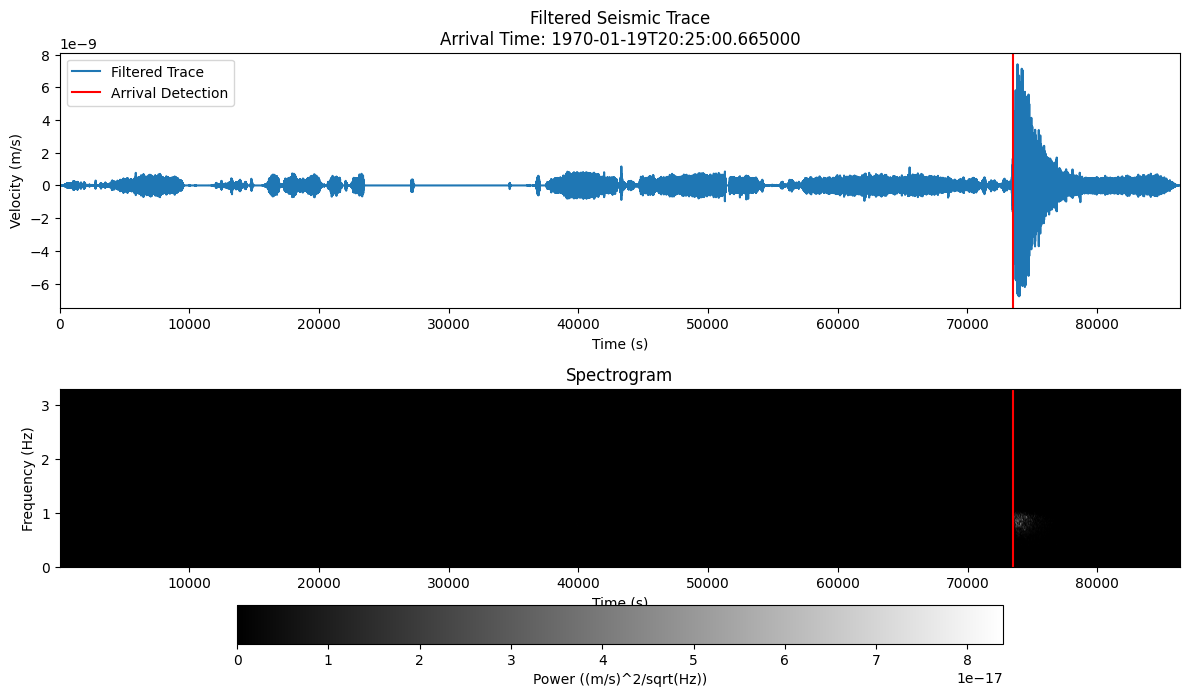

In [21]:
if __name__ == "__main__":
    main()

In [20]:
 #Assuming the images are already saved in a directory
def load_existing_images(image_dir):
    """
    Load the paths of pre-generated images from the given directory.
    """
    image_files = []
    for root, _, files in os.walk(image_dir):
        for file in files:
            if file.endswith('.png'):
                image_files.append(os.path.join(root, file))
    return image_files

def preprocess_lunar_data(lunar_data_directory):
    """
    Skip generating images and directly load pre-generated lunar images.
    """
    print(f"Loading pre-generated lunar images from {lunar_data_directory}...")
    lunar_images = load_existing_images(lunar_data_directory)
    print(f"{len(lunar_images)} lunar images loaded.")
    return lunar_images

def preprocess_martian_data(martian_data_directory):
    """
    Skip generating images and directly load pre-generated Martian images.
    """
    print(f"Loading pre-generated Martian images from {martian_data_directory}...")
    martian_images = load_existing_images(martian_data_directory)
    print(f"{len(martian_images)} Martian images loaded.")
    return martian_images


In [37]:
import os

def main():
    # Define the path where preprocessed images are stored
    lunar_data_images_dir = '../../model/model_output/lunar_preprocessed_images/'
    # Load pre-generated lunar images
    print(f"Loading pre-generated lunar data from: {lunar_data_images_dir}")
    
    # List all image files in the directory
    lunar_data_images = [os.path.join(lunar_data_images_dir, f) for f in os.listdir(lunar_data_images_dir) if f.endswith('.png')]
    
    # Debugging to ensure consistent data lengths
    print(f"Lunar Data: {len(lunar_data_images)} images")

    # Confirm that the image files exist and are correct
    if len(lunar_data_images) > 0:
        for i in range(min(5, len(lunar_data_images))):  # Checking the first 5 file paths
            img_path = lunar_data_images[i]
            if os.path.exists(img_path) and img_path.endswith('.png'):
                print(f"Valid image path: {img_path}")
            else:
                print(f"Invalid image path or file does not exist: {img_path}")
    else:
        print("Error: No lunar image data found. Skipping the training process.")
        return  # Exit the function early if no data is found

    # Assuming lunar labels and arrival times are stored or generated elsewhere
    # Placeholder for labels and arrival times, adjust according to your logic
    lunar_labels_encoded = [0] * len(lunar_data_images)  # Placeholder labels
    lunar_arrival_times_numeric = [0] * len(lunar_data_images)  # Placeholder arrival times

    # Split data into training and validation sets
    print("Splitting lunar data into training and validation sets...")
    X_train, X_val, y_event_train, y_event_val, y_time_train, y_time_val = train_test_split(
        lunar_data_images, lunar_labels_encoded, lunar_arrival_times_numeric, test_size=0.2, random_state=42
    )

    # Convert processed lunar data to DataLoader for training
    print("Preparing DataLoader for lunar training data...")
    train_loader = prepare_data_for_training(X_train, y_event_train, y_time_train)
    val_loader = prepare_data_for_training(X_val, y_event_val, y_time_val)

    # Check if the data loader is valid
    if train_loader is not None:
        print("DataLoader successfully created for training.")
    else:
        print("Error: DataLoader creation failed.")

    # Initialize the model and define loss functions and optimizer
    print("Initializing SpectrogramCNN model...")
    model = SpectrogramCNN()
    criterion_event = nn.CrossEntropyLoss()
    criterion_time = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train the model on lunar data
    print("Training model on lunar data...")
    if train_loader:
        train_model(model, train_loader, criterion_event, criterion_time, optimizer)
    else:
        print("Error: Training skipped due to invalid DataLoader.")

    # Save the trained model
    print("Saving the trained model...")
    save_model_artifacts(model)
    print("Model saved successfully.")

In [ ]:
if __name__ == "__main__":
    main()

# Process Martian Data, Save Images and Train

In [82]:
def preprocess_martian_data(data_dir, save_dir, combine_images=True):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    martian_images = []
    martian_arrival_times = []

    # List all .mseed files in the data directory
    mseed_files = [f for f in os.listdir(data_dir) if f.endswith('.mseed')]

    if len(mseed_files) == 0:
        print("No .mseed files found in the directory.")
        return martian_images, martian_arrival_times

    # Iterate over each .mseed file
    for filename in mseed_files:
        file_path = os.path.join(data_dir, filename)

        # Derive the corresponding CSV file path from the .mseed filename
        csv_file_name = filename.replace('.mseed', '.csv')
        csv_file_path = os.path.join(data_dir, csv_file_name)

        # Ensure the CSV file exists before processing
        if not os.path.exists(csv_file_path):
            print(f"CSV file not found for {filename}: {csv_file_path}")
            continue

        # Read the CSV file to get the rel_time (relative time in seconds)
        try:
            csv_data = pd.read_csv(csv_file_path)
            if 'rel_time(sec)' not in csv_data.columns:
                print(f"CSV does not contain 'rel_time(sec)': {csv_file_path}")
                continue
            arrival_time_rel = csv_data['rel_time(sec)'].iloc[0]
        except Exception as e:
            print(f"Error reading CSV file {csv_file_path}: {e}")
            continue

        # Process and generate spectrogram
        try:
            image_path = plot_and_save_trace_spectrogram(file_path, arrival_time_rel, save_dir, filename, combine_images)
            martian_images.append(image_path)
            martian_arrival_times.append(arrival_time_rel)
        except Exception as e:
            print(f"Error processing {file_path}: {e}")
    
    return martian_images, martian_arrival_times

In [83]:
def self_train_on_martian_data(model, data_loader, optimizer, criterion_event, criterion_time, num_epochs=10):
    model.train()
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (images, event_labels, time_labels) in enumerate(data_loader):
            optimizer.zero_grad()

            event_output, time_output = model(images)
            loss_event = criterion_event(event_output, event_labels)
            loss_time = criterion_time(time_output.squeeze(), time_labels)
            total_loss = loss_event + loss_time

            total_loss.backward()
            optimizer.step()

            running_loss += total_loss.item()

        print(f"Epoch {epoch+1}, Loss: {running_loss/len(data_loader)}")


In [84]:
from sklearn.metrics import accuracy_score, mean_absolute_error

def evaluate_model(model, data_loader):
    model.eval()
    event_preds, time_preds, event_true, time_true = [], [], [], []
    
    with torch.no_grad():
        for images, event_labels, time_labels in data_loader:
            images, event_labels, time_labels = images.to(device), event_labels.to(device), time_labels.to(device)

            event_output, time_output = model(images)

            # Gather predictions and true values for validation metrics
            _, event_pred_classes = torch.max(event_output, 1)
            event_preds.extend(event_pred_classes.cpu().numpy())
            time_preds.extend(time_output.cpu().numpy())
            event_true.extend(event_labels.cpu().numpy())
            time_true.extend(time_labels.cpu().numpy())

    # Calculate validation metrics
    event_accuracy = accuracy_score(event_true, event_preds)
    time_mae = mean_absolute_error(time_true, time_preds)

    print(f"Validation Event Accuracy: {event_accuracy:.4f}")
    print(f"Validation Time MAE: {time_mae:.4f}")

    # Optionally: plot loss curves, accuracy, confusion matrix, etc.
    plot_metrics(event_true, event_preds)


In [85]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

def plot_metrics(event_true, event_preds):
    # Example: Plot confusion matrix (for event classification)
    ConfusionMatrixDisplay.from_predictions(event_true, event_preds)
    plt.title("Confusion Matrix for Event Classification")
    plt.show()
    
    # Optionally: You can plot loss/accuracy curves here


In [86]:
martian_image_dir = '../../model/model_output/martian_preprocessed_images/'
martian_data_dir = '../../data/marsquake_data/training/data/'
martian_catalog_path = '../../data/marsquake_data/training/catalogs/Mars_InSight_training_catalog.csv'

In [87]:
def main():
    # Preprocess and load Martian data
    print("Preprocessing Martian data...")
    martian_data_images, martian_arrival_times = preprocess_martian_data(martian_data_dir, save_dir, combine_images=True)

    # Placeholder labels for Martian data (self-training)
    martian_labels = [0] * len(martian_data_images)  # Placeholder labels
    
    print("Loading the pre-trained model...")
    model = SpectrogramCNN()
    state_dict = torch.load('seismic_cnn_model_weights.pth')
    model.load_state_dict(state_dict)

    # Define the loss functions and optimizer
    print("Defining loss functions and optimizer...")
    criterion_event = nn.CrossEntropyLoss()
    criterion_time = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Prepare DataLoader for Martian data (self-training)
    print("Self-training model on Martian data...")
    martian_data_loader = prepare_data_for_training(martian_data_images, martian_labels, martian_arrival_times)

    if martian_data_loader:
        self_train_on_martian_data(model, martian_data_loader, optimizer, criterion_event, criterion_time)
    else:
        print("Error: Self-training skipped due to invalid DataLoader for Martian data.")

    # Save the fine-tuned model
    save_model_artifacts(model, model_name='fine_tuned_martian_seismic_cnn')

In [ ]:
if __name__ == "__main__":
    main()